In [1]:
import numpy as np
import sys, os
from imageio.v2 import imread
import pywt
from tqdm import tqdm
from skimage.restoration import denoise_wavelet, estimate_sigma
from functools import partial
# rescale_sigma=True required to silence deprecation warnings
_denoise_wavelet = partial(denoise_wavelet, rescale_sigma=True)
import scipy.stats as stats
from scipy.stats import gmean
import cv2
import matplotlib.pyplot as plt

In [53]:
# =========================================================
def rescale(dat,mn,mx):
    """
    rescales an input dat between mn and mx
    """
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

##====================================
def standardize(img):
    img = np.array(img)
    #standardization using adjusted standard deviation
    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0/np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    img = rescale(img, 0, 1)
    del m, s, N

    return img

In [3]:
image= "B_4.jpg"
resolution = 0.074519231
img = cv2.imread(image)
nxx, nyy, _ = img.shape
width = max(nxx, nyy)
maxscale= width*resolution / 8

x= 0
verbose = 1

Stage 1: read image

In [4]:
im = imread(image)   # read the image straight with imread
im = np.squeeze(im)  # squeeze singleton dimensions
if len(np.shape(im))>3:
    im = im[:, :, :3]            # only keep the first 3 bands

if len(np.shape(im))==3: # if rgb, convert to grey
    im = (0.299 * im[:,:,0] + 0.5870*im[:,:,1] + 0.114*im[:,:,2]).astype('uint8')

nx,ny = np.shape(im)
if nx>ny:
    im=im.T

im = standardize(im)

Stage 2: Denoised image using default parameters of `denoise_wavelet`

In [5]:
filter=False

if filter:
    sigma_est = estimate_sigma(im, multichannel=False, average_sigmas=True)
    region = denoise_wavelet(im, multichannel=False, rescale_sigma=True,
                                method='VisuShrink', mode='soft', sigma=sigma_est*2)
else:
    region = im.copy()

original = rescale(region,0,255)

nx, ny = original.shape


Stage 3: Call cwt to get particle size distribution

In [54]:
P_og = []; M_og = []
for k in np.linspace(1,nx-1,100):
    [cfs_og, frequencies_og] = pywt.cwt(original[int(k),:], np.arange(3, np.maximum(nx,ny)/maxscale, 1),  'morl' , .5)
    period_og = 1. / frequencies_og
    power_og =(abs(cfs_og)) ** 2
    power_og = np.mean(np.abs(power_og), axis=1)/(period_og**2)
    P_og.append(power_og)

    M_og.append(period_og[np.argmax(power_og)])

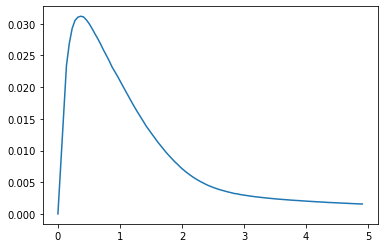

In [55]:
p_og = np.mean(np.vstack(P_og), axis=0)
p_og = np.array(p_og/np.sum(p_og))

# get real scales by multiplying by resolution (mm/pixel)
scales_og = np.array(period_og)

srt_og = np.sqrt(np.sum(p_og*((scales_og-np.mean(M_og))**2)))

# plt.plot(scales, p,'m', lw=2)

p_og = p_og+stats.norm.pdf(scales_og, np.mean(M_og), srt_og/2)
p_og = np.hstack([0,p_og])
scales_og = np.hstack([0,scales_og])
p_og = p_og/np.sum(p_og)
x_og = 0
# area-by-number to volume-by-number
r_v_og = (p_og*scales_og**x_og) / np.sum(p_og*scales_og**x_og) #volume-by-weight proportion

plt.plot((scales_og*resolution), r_v_og)
plt.show()

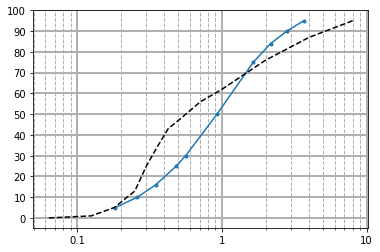

In [56]:
pd_og = np.interp([.05,.1,.16,.25,.3,.5,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_og))), np.hstack((0,scales_og)) )
data_B_og = pd_og * resolution

sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
sieve_A = [100, 100, 100, 99, 97, 90, 85, 76, 64, 44, 18, 2, 0]
sieve_B = [95, 87, 76, 62, 56, 47, 43, 34, 25, 13, 5, 1, 0]
percentile_C = [5, 10, 16, 25, 30, 50,  75, 84, 90, 95] 
plt.plot(data_B_og, percentile_C, marker='.')
plt.plot(sieve_open, sieve_B, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

Testing


In [9]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / .1), np.maximum(nx,ny)/(width*resolution / 1), 1),  'morl', 1) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_1 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_1-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_1, np.mean(M), srt/2)
p = np.hstack([0,p])
scales_1 = np.hstack([0,scales_1])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_1 = (p*scales_1**x) / np.sum(p*scales_1**x) #volume-by-weight proportion

In [46]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 1), np.maximum(nx,ny)/(width*resolution / 2), 1),  'morl', .5) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_2 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_2-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_2, np.mean(M), srt/2)
p = np.hstack([0,p])
scales_2 = np.hstack([0,scales_2])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_2 = (p*scales_2**x) / np.sum(p*scales_2**x) #volume-by-weight proportion



In [11]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 2), np.maximum(nx,ny)/(width*resolution / 3), 1),  'morl', 1) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_3 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_3-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_3, np.mean(M), srt/2)
p = np.hstack([0,p])
scales_3 = np.hstack([0,scales_3])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_3 = (p*scales_3**x) / np.sum(p*scales_3**x) #volume-by-weight proportion

In [45]:
print(np.arange(np.maximum(nx,ny)/(width*resolution / 2), np.maximum(nx,ny)/(width*resolution / 3), 1))

[26.83870959 27.83870959 28.83870959 29.83870959 30.83870959 31.83870959
 32.83870959 33.83870959 34.83870959 35.83870959 36.83870959 37.83870959
 38.83870959 39.83870959]


In [12]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 3), np.maximum(nx,ny)/(width*resolution / 4), 1),  'morl', 1) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_4 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_4-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_4, np.mean(M), srt/2)
p = np.hstack([0,p])
scales_4 = np.hstack([0,scales_4])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_4 = (p*scales_4**x) / np.sum(p*scales_4**x) #volume-by-weight proportion

In [13]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 4), np.maximum(nx,ny)/(width*resolution / 5), 1),  'morl', 1) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_5 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_5-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_5, np.mean(M), srt/2)
p = np.hstack([0,p])
scales_5 = np.hstack([0,scales_5])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_5 = (p*scales_5**x) / np.sum(p*scales_5**x) #volume-by-weight proportion

In [14]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 5), np.maximum(nx,ny)/(width*resolution / 6), 1),  'morl', 1) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_6 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_6-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_6, np.mean(M), srt/2)
p = np.hstack([0,p])
scales_6 = np.hstack([0,scales_6])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_6 = (p*scales_6**x) / np.sum(p*scales_6**x) #volume-by-weight proportion

In [15]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 6), np.maximum(nx,ny)/(width*resolution / 7), 1),  'morl', 1) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_7 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_7-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_7, np.mean(M), srt/2)
p = np.hstack([0,p])
scales_7 = np.hstack([0,scales_7])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_7 = (p*scales_7**x) / np.sum(p*scales_7**x) #volume-by-weight proportion

In [57]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 7), np.maximum(nx,ny)/(width*resolution / 8), 1),  'morl', .5) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_8 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_8-np.mean(M))**2)))

# plt.plot(scales, p,'m', lw=2)

p = p+stats.norm.pdf(scales_8, np.mean(M), srt/2)
p = np.hstack([0,p])
scales_8 = np.hstack([0,scales_8])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_8 = (p*scales_8**x) / np.sum(p*scales_8**x) #volume-by-weight proportion

In [ ]:
print(scales_1)
print(len(r_v_1))
print(np.mean(r_v_1))
plt.plot(scales_1*resolution, r_v_1); plt.show()

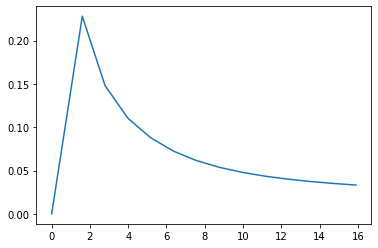

In [17]:
P = []; M = []
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / .1), np.maximum(nx,ny)/(width*resolution / 1), 1),  'cmorl14-0.07142857142857142', 1) #cmor10-8
    period = 1. / frequencies
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales_1 = np.array(period)

srt = np.sqrt(np.sum(p*((scales_1-np.mean(M))**2)))

p = p+stats.norm.pdf(scales_1, np.mean(M), srt/2)
p = np.hstack([0,p])
scales_1 = np.hstack([0,scales_1])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v_1 = (p*scales_1**x) / np.sum(p*scales_1**x) #volume-by-weight proportion

plt.plot(scales_1*resolution, r_v_1); plt.show()

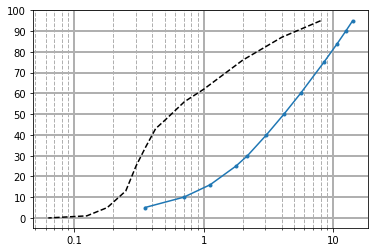

In [18]:

pd1 = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_1))), np.hstack((0,scales_1)) ) * resolution

sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
sieve_A = [100, 100, 100, 99, 97, 90, 85, 76, 64, 44, 18, 2, 0]
sieve_B = [95, 87, 76, 62, 56, 47, 43, 34, 25, 13, 5, 1, 0]
percentile_C = [5, 10, 16, 25, 30, 40, 50, 60, 75, 84, 90, 95] 
# plt.plot(data_B, percentile_C, marker='.')
plt.plot(pd1, percentile_C, marker='.')
plt.plot(sieve_open, sieve_B, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

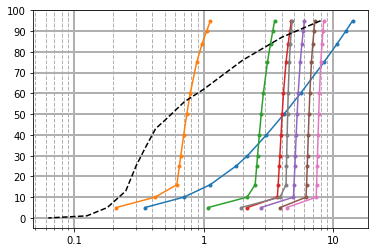

In [58]:
r_v = np.concatenate((r_v_1, r_v_2, r_v_3, r_v_4, r_v_5, r_v_6, r_v_7, r_v_8))
scales = np.concatenate((scales_1, scales_2, scales_3, scales_4, scales_5, scales_6, scales_7, scales_8))

pd1 = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_1))), np.hstack((0,scales_1)) ) * resolution
pd2 = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_2))), np.hstack((0,scales_2)) )* resolution
pd3 = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_3))), np.hstack((0,scales_3)) )* resolution
pd4 = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_4))), np.hstack((0,scales_4)) )* resolution
pd5 = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_5))), np.hstack((0,scales_5)) )* resolution
pd6 = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_6))), np.hstack((0,scales_6)) )* resolution
pd7 = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_7))), np.hstack((0,scales_7)) )* resolution
pd8 = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v_8))), np.hstack((0,scales_8)) )* resolution
# data_B = pd * resolution


sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
sieve_A = [100, 100, 100, 99, 97, 90, 85, 76, 64, 44, 18, 2, 0]
sieve_B = [95, 87, 76, 62, 56, 47, 43, 34, 25, 13, 5, 1, 0]
percentile_C = [5, 10, 16, 25, 30, 40, 50, 60, 75, 84, 90, 95] 
# plt.plot(data_B, percentile_C, marker='.')
plt.plot(pd1, percentile_C, marker='.')
plt.plot(pd2, percentile_C, marker='.')
plt.plot(pd3, percentile_C, marker='.')
plt.plot(pd4, percentile_C, marker='.')
plt.plot(pd5, percentile_C, marker='.')
plt.plot(pd6, percentile_C, marker='.')
plt.plot(pd7, percentile_C, marker='.')
plt.plot(pd8, percentile_C, marker='.')
plt.plot(sieve_open, sieve_B, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

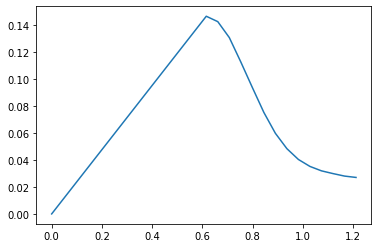

[0.         0.1462571  0.14225963 0.13047351 0.11239388 0.09353882
 0.07506758 0.05964116 0.04826395 0.04027394 0.03513872 0.03186829
 0.02984099 0.02799813 0.02698432]
(14,)
(15,)
0.22813572176449465
0.14625709656781868
0.11801511801981777
0.11627838372766641
0.11334592703126914
0.11532598730511444
0.11401097006616293
0.11215591786658297


In [48]:
plt.plot(scales_2*resolution, r_v_2); plt.show()
print(r_v_2)
print(np.shape(np.arange(np.maximum(nx,ny)/(width*resolution / 1), np.maximum(nx,ny)/(width*resolution / 2), 1)))
print(np.shape(r_v_2))
print(max(r_v_1))
print(max(r_v_2))
print(max(r_v_3))
print(max(r_v_4))
print(max(r_v_5))
print(max(r_v_6))
print(max(r_v_7))
print(max(r_v_8))

In [50]:
#r_test =  [0.12948384, 0.12524869, 0.11590361, 0.1019109,  0.08841109, 0.07487397, 0.06343877, 0.0549071,  0.048564, 0.04423367, 0.04120216, 0.03913628, 0.03696208, 0.03572382]
r_test = [0.1462571,  0.14225963, 0.13047351, 0.11239388, 0.09353882, 0.07506758, 0.05964116, 0.04826395, 0.04027394, 0.03513872, 0.03186829, 0.02984099, 0.02799813, 0.02698432]
#scales_test = [16.51612898, 17.74689821, 18.97766744, 20.20843667, 21.4392059, 22.66997513, 23.90074437, 25.1315136, 26.36228283, 27.59305206, 28.82382129, 30.05459052, 31.28535975, 32.51612898]
scales_test = [8.25806449,  8.87344911,  9.48883372, 10.10421834, 10.71960295, 11.33498757, 11.95037218, 12.5657568,  13.18114141, 13.79652603, 14.41191064, 15.02729526, 15.64267988, 16.25806449]
scales_test = np.array(scales_test)
r_test = np.array(r_test)
pdtest = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_test))), np.hstack((0,scales_test)) )* resolution

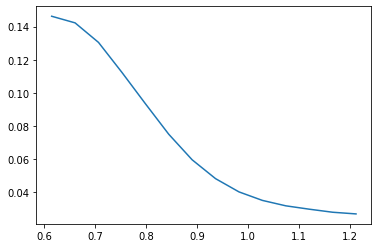

In [51]:
plt.plot(scales_test*resolution, r_test); plt.show()

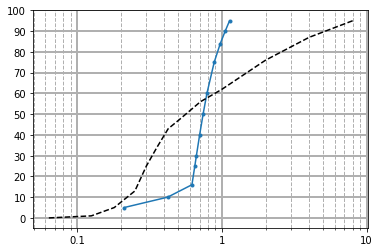

In [52]:
sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
sieve_A = [100, 100, 100, 99, 97, 90, 85, 76, 64, 44, 18, 2, 0]
sieve_B = [95, 87, 76, 62, 56, 47, 43, 34, 25, 13, 5, 1, 0]
percentile_C = [5, 10, 16, 25, 30, 40, 50, 60, 75, 84, 90, 95] 
# plt.plot(data_B, percentile_C, marker='.')
plt.plot(pdtest, percentile_C, marker='.')
plt.plot(sieve_open, sieve_B, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [ ]:
xxx = np.mean(np.arange(np.maximum(nx,ny)/(width*resolution / 0.1), np.maximum(nx,ny)/(width*resolution / .5), .5))

print(pywt.scale2frequency('morl', xxx)/1) 
print(1/0.15164057850790216)

In [ ]:
P = []; M = []; Freq=[]
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(np.maximum(nx,ny)/(width*resolution / 0.1), np.maximum(nx,ny)/(width*resolution / 1), 1), 'cmor7-0.03363715312499999',.5) #cmor10-8
    period = 1. / frequencies
    Freq.append(frequencies)
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales = np.array(period)

srt = np.sqrt(np.sum(p*((scales-np.mean(M))**2)))


p = p+stats.norm.pdf(scales, np.mean(M), srt/2)
p = np.hstack([0,p])
scales = np.hstack([0,scales])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v = (p*pow(scales,x)) / np.sum(p*pow(scales,x)) #volume-by-weight proportion


pd = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
data_C = pd * resolution

sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
percentile_C = [5, 10, 16, 25, 30, 40, 50, 60, 75, 84, 90, 95] 
plt.plot(data_C, percentile_C, marker='.')
plt.plot(sieve_open, sieve_C, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [ ]:
print(data_C)


In [ ]:
P = []; M = []
for k in np.linspace(1,nx-1,10):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(3, np.maximum(nx,ny)/(width*resolution / 8), 1),  'morl', 1) #cmor10-8
    period = 1. / frequencies
    print(np.shape(cfs))
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])




In [ ]:
print(np.shape(P))
print(period)

In [ ]:
P = []; M = []; Freq=[]
for k in np.linspace(1,nx-1,100):
    [cfs, frequencies] = pywt.cwt(original[int(k),:], np.arange(3, np.maximum(nx,ny)/(width*resolution / 8), 1), 'morl',.5) #cmor10-8
    period = 1. / frequencies
    Freq.append(frequencies)
    power =(abs(cfs)) ** 2
    power = np.mean(np.abs(power), axis=1)/(period**2)
    P.append(power)

    M.append(period[np.argmax(power)])

p = np.mean(np.vstack(P), axis=0)
p = np.array(p/np.sum(p))

# get real scales by multiplying by resolution (mm/pixel)
scales = np.array(period) 

srt = np.sqrt(np.sum(p*((scales-np.mean(M))**2)))


p = p+stats.norm.pdf(scales, np.mean(M), srt/2)
p = np.hstack([0,p])
scales = np.hstack([0,scales])
p = p/np.sum(p)
x = 0
# area-by-number to volume-by-number
r_v = (p*pow(scales,x)) / np.sum(p*pow(scales,x)) #volume-by-weight proportion


pd = np.interp([.05,.1,.16,.25,.3,.4,.5,.6,.75,.84,.9,.95],np.hstack((0,np.cumsum(r_v))), np.hstack((0,scales)) )
data_B = pd  * resolution

sieve_open = [8, 4, 2, 1, 0.71, 0.5, 0.425, 0.355, 0.3, 0.25, 0.18, 0.125, 0.063]
sieve_C = [98, 93, 76, 55, 40, 22, 16, 9, 5, 2, 0, 0, 0]
sieve_A = [100, 100, 100, 99, 97, 90, 85, 76, 64, 44, 18, 2, 0]
sieve_B = [95, 87, 76, 62, 56, 47, 43, 34, 25, 13, 5, 1, 0]
percentile_C = [5, 10, 16, 25, 30, 40, 50, 60, 75, 84, 90, 95] 
plt.plot(data_B, percentile_C, marker='.')
plt.plot(sieve_open, sieve_B, ls='--', color='black')

plt.xscale("log")
plt.grid(which='major', linewidth=2, linestyle='-')
plt.grid(which='minor', linewidth=1, linestyle='--')
plt.yticks(np.arange(0,110, 10), ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'] )
plt.xticks([0.1, 1, 10], [0.1,1,10])

plt.show()

In [ ]:
plt.plot(scales*resolution, r_v,'k', lw=2); plt.show()